In [1]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io as sio
import seaborn as sns
import ancillary as ac
import matplotlib as mpl
import matplotlib.pyplot as plt
from nilearn import plotting
from PyPDF2 import PdfFileMerger
from natsort import natsorted
import statsmodels.api as sm
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.manova import MANOVA
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
def zscore(data, axis):
    data -= data.mean(axis=axis, keepdims=True)
    data /= data.std(axis=axis, keepdims=True)
    return np.nan_to_num(data, copy=False)

def correlation(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)

In [3]:
sz_smri_data_path = "/Users/xli77/Documents/MISA/MISA-data/sMRI-fMRI-DTI/mancovaOuts_allHCSZ_combinedRelatives_wX_preregSite_C30_SMRI_GICAinit.mat"
sz_smri_data = sio.loadmat(sz_smri_data_path)['NMODELHCSZ0ns']
sz_smri_data_array = sz_smri_data[0][0][0]
age = sz_smri_data_array[:,0]
sex = sz_smri_data_array[:,1]
diagnosis = sz_smri_data_array[:,2]
id = sio.loadmat("/Users/xli77/Documents/MISA/MISA-data/sMRI-fMRI-DTI/SZID.mat")['ID'][0] - 1

# diagnosis label
# HCid = find(DEMO0_AllwX_preregSite_GICAinit.full(:,3)==0);
# SZid = find(DEMO0_AllwX_preregSite_GICAinit.full(:,3)==1);
# BPid = find(DEMO0_AllwX_preregSite_GICAinit.full(:,3)==2);
# SZAid = find(DEMO0_AllwX_preregSite_GICAinit.full(:,3)==3);
# SADBPPid = find(DEMO0_AllwX_preregSite_GICAinit.full(:,3)==4);
# SADEPPid = find(DEMO0_AllwX_preregSite_GICAinit.full(:,3)==5);

In [4]:
Xpath="/Users/xli77/Documents/MISA/MISA-data/sMRI-fMRI/X_sz.mat"
X=sio.loadmat(Xpath)['X']
X=np.squeeze(X)

In [5]:
datapath="/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/um2mm/"
subspace_struct_list=['234111','2222211','333111','441111','12x1']
num_subspace_struct=len(subspace_struct_list)

Y = np.zeros((num_subspace_struct,3,2,12,999)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
W = np.zeros((num_subspace_struct,3,2,12,44318)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source

num_iter=21
corr = np.zeros((num_subspace_struct,9,12,12))
# loss_um=np.zeros((num_subspace_struct,num_iter))
# loss_ummm=np.zeros((num_subspace_struct,num_iter))
# aux_um=np.zeros((num_subspace_struct,num_iter))
# aux_ummm=np.zeros((num_subspace_struct,num_iter))

for i,ss in enumerate(subspace_struct_list):

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz_Y.mat"))
    Y1=np.squeeze(data['Y1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz_Y.mat"))
    Y2=np.squeeze(data['Y2'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz_Y.mat"))
    Y3=np.squeeze(data['Y3'])

    Y[i,0,0]=Y1[0][:,id]
    Y[i,0,1]=Y1[1][:,id]
    Y[i,1,0]=Y2[0][:,id]
    Y[i,1,1]=Y2[1][:,id]
    Y[i,2,0]=Y3[0][:,id]
    Y[i,2,1]=Y3[1][:,id]

    # for j in range(2):
    #     for k in range(2):
    #         for l in range(12):
    #             sgn = np.sign(correlation(Y[i,j,k,l],age))
    #             Y[i,j,k,l] = -sgn * Y[i,j,k,l]

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz_W.mat"))
    W1=np.squeeze(data['W1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz_W.mat"))
    W2=np.squeeze(data['W2'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz_W.mat"))
    W3=np.squeeze(data['W3'])

    W[i,0,0]=W1[0]
    W[i,0,1]=W1[1]
    W[i,1,0]=W2[0]
    W[i,1,1]=W2[1]
    W[i,2,0]=W3[0]
    W[i,2,1]=W3[1]

    corr[i,0] = np.corrcoef(Y1[0],Y1[0])[:12,:12]
    corr[i,1] = np.corrcoef(Y1[1],Y1[1])[:12,:12]
    corr[i,2] = np.corrcoef(Y1[0],Y1[1])[12:,:12]

    corr[i,3] = np.corrcoef(Y2[0],Y2[0])[:12,:12]
    corr[i,4] = np.corrcoef(Y2[1],Y2[1])[:12,:12]
    corr[i,5] = np.corrcoef(Y2[0],Y2[1])[12:,:12]

    corr[i,6] = np.corrcoef(Y3[0],Y3[0])[:12,:12]
    corr[i,7] = np.corrcoef(Y3[1],Y3[1])[:12,:12]
    corr[i,8] = np.corrcoef(Y3[0],Y3[1])[12:,:12]

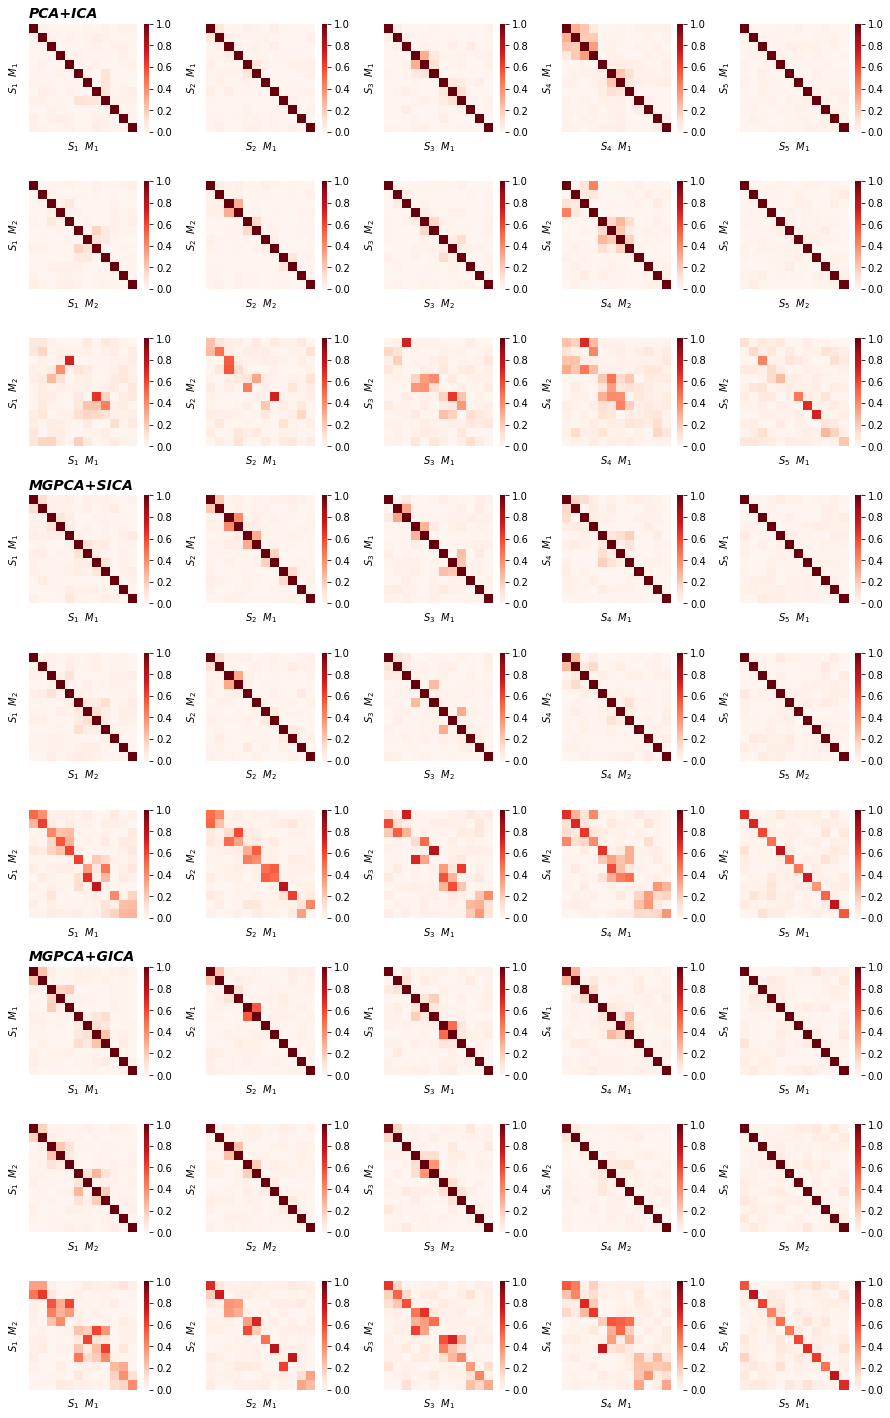

In [6]:
# cmap_list=["YlGn","YlGn","Purples","Purples"]
analysis_list = ["PCA+ICA"]*3+["MGPCA+ICA"]*3+["MGPCA+GICA"]*3

fig,axes=plt.subplots(9,num_subspace_struct,figsize=(2.5*num_subspace_struct,2.2*9))

for i in range(num_subspace_struct):
    for j in range(9):
        if j == 2 or j == 5 or j == 8:
            sns.heatmap(np.abs(corr[i,j]),cmap="Reds",vmin=0,vmax=1,ax=axes[j,i])#Purples
            axes[j,i].set_xlabel(f"$S_{i+1}$  $M_1$")
            axes[j,i].set_ylabel(f"$S_{i+1}$  $M_2$")
            # axes[j,i].set_title(f"$S_{i+1}$  $M_1$ vs $M_2$")
            # axes[j,i].set_title(f"{analysis_list[j]}  $S_{i+1}$  $M_1$ vs $M_2$")#cross-correlation
        else:
            sns.heatmap(np.abs(corr[i,j]),cmap="Reds",vmin=0,vmax=1,ax=axes[j,i])#Purples
            axes[j,i].set_xlabel(f"$S_{i+1}$  $M_{j%3+1}$")
            axes[j,i].set_ylabel(f"$S_{i+1}$  $M_{j%3+1}$")
            # axes[j,i].set_title(f"$~~S_{i+1}$  $M_{j%3+1}$")
            # axes[j,i].set_title(f"{analysis_list[j]}  $S_{i+1}$  $M_{j%3+1}$")#self-correlation($Y$)
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        # axes[j,i].set_axis_off()
        if i == 0 and j == 0:
            axes[j][i].set_title(analysis_list[j], loc="left", fontsize=14, fontstyle="italic", fontweight="bold")
        if i == 0 and j == 3:
            axes[j][i].set_title(analysis_list[j], loc="left", fontsize=14, fontstyle="italic", fontweight="bold")
        if i == 0 and j == 6:
            axes[j][i].set_title(analysis_list[j], loc="left", fontsize=14, fontstyle="italic", fontweight="bold")

plt.tight_layout()
# plt.savefig("neuroimaging_sz_iva.png",dpi=500)
# plt.savefig("neuroimaging_sz_iva.pdf")

In [7]:
num_iter=21
loss_um=np.zeros((num_subspace_struct,num_iter))
loss_ummm=np.zeros((num_subspace_struct,num_iter))
loss_mm=np.zeros((num_subspace_struct,num_iter))

for i,ss in enumerate(subspace_struct_list):
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_um'][2,:])
        loss_um[i,:] = a
    else:
        a = np.squeeze(data['aux_um'][1,:])
        loss_um[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_ummm'][2,:])
        loss_ummm[i,:] = a
    else:
        a = np.squeeze(data['aux_ummm'][1,:])
        loss_ummm[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_mm'][2,:])
        loss_mm[i,:] = a
    else:   
        a = np.squeeze(data['aux_mm'][1,:])
        loss_mm[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

In [8]:
loss_um_min = np.min(loss_um,axis=1)
loss_ummm_min = np.min(loss_ummm,axis=1)
loss_mm_min = np.min(loss_mm,axis=1)

print(loss_um_min)
print(loss_ummm_min)
print(loss_mm_min)

[47.3608643  47.3497337  47.33591581 47.40435794 47.5266368 ]
[45.77476546 45.67367945 45.78780006 45.92366029 45.69615974]
[31.71414245 31.62090419 31.68663272 31.85561243 31.6514719 ]


In [6]:
subspace_struct_list=['234111','2222211','333111','441111']

A = np.zeros((4,3,2,X[0].shape[0],12)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source

for i,ss in enumerate(subspace_struct_list):
    for j,a in enumerate(["um","ummm","mm"]):
        for k,m in enumerate([0,1]):
            data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}",f"{a}_neuroimaging_sz_Y.mat"))
            Y_=np.squeeze(data[f'Y{j+1}'])[k][:,id]
            At = np.linalg.inv(Y_ @ Y_.T) @ (Y_ @ X[k][:,id].T)
            A[i,j,k] = At.T

# sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/A_sz.mat", {"A": A})

In [7]:
WAY_list = []
cca_corr_list = []

for i in np.arange(0,10,2):
    # S1-4, UA/MSIVA, M1-2, voxel, source
    A1 = A[1,1,0,:,i:i+2] # structure 2, MSIVA, M1, subspace 1
    A2 = A[1,1,1,:,i:i+2] # structure 2, MSIVA, M2, subspace 1

    Y1 = Y[1,1,0,i:i+2] 
    Y2 = Y[1,1,1,i:i+2] 

    AY1 = A1@Y1
    AY2 = A2@Y2

    # PCA AY1, AY2
    AY1_p, AY1_p_projM, AY1_p_projM_std = ac.base_PCA(AY1, num_PC=None, axis=-2, whitening=True)
    AY2_p, AY2_p_projM, AY2_p_projM_std = ac.base_PCA(AY2, num_PC=None, axis=-2, whitening=True)

    # Post-PCA eigenvalue problem for CCA
    S12 = AY1_p @ AY2_p.T
    Z1 = np.zeros((AY1_p.shape[0],AY1_p.shape[0]), dtype=AY1_p.dtype)
    Z2 = np.zeros((AY2_p.shape[0],AY2_p.shape[0]), dtype=AY2_p.dtype)
    J = np.block([[Z1, S12],[S12.T, Z2]])
    U, S = ac.do_cov_EVD(J, k=2) # here, k = smallest subspace size in each modality

    # Final transformations: these multiply AY
    W1 = U[:2,].T @ AY1_p_projM
    W2 = U[2:,].T @ AY2_p_projM

    WAY1 = W1 @ AY1
    WAY2 = W2 @ AY2
    WAY_list.append( [WAY1, WAY2] )

    cca_corr = np.corrcoef(WAY1, WAY2)[2:,0:2]
    cca_corr_list.append(cca_corr)

# cca = CCA(n_components=2)
# cca.fit(AY1_p, AY2_p)
# WAY1_cca, WAY2_cca = cca.transform(AY1_p, AY2_p)

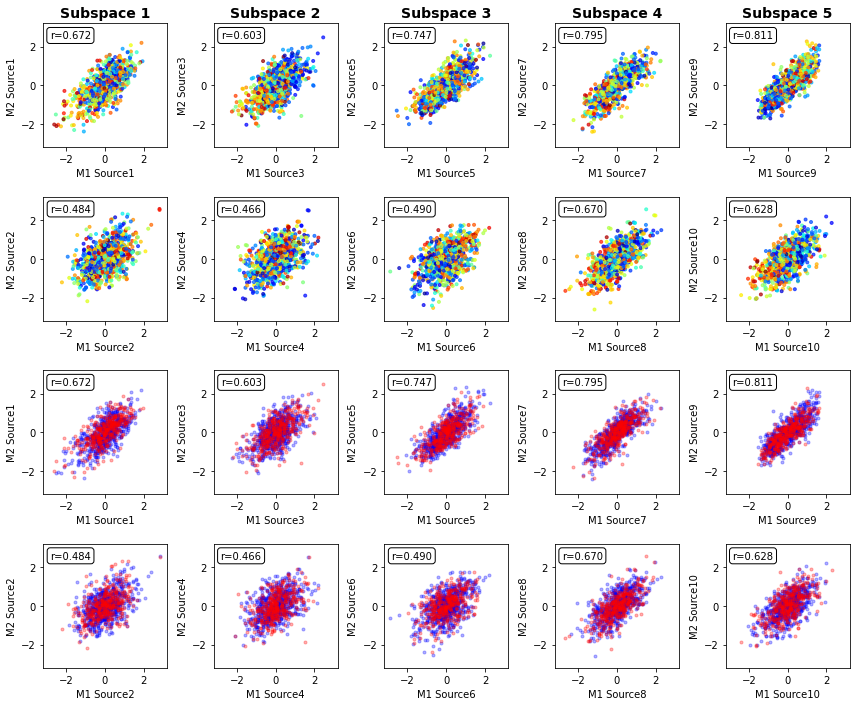

In [17]:
cols = plt.cm.jet(np.linspace(0,1,round(max(age)-min(age)+1)))

# CCA, color coded by age/sex
scv_list = []
for i in np.arange(0,10,2):
    scv_list.append([f"Source{i+1}", f"Source{i+2}"])

fig, axes = plt.subplots(4,5,figsize=(12,10))

for k in range(5):
    for i in range(2):
        WAY1 = WAY_list[k][0]#[:,id]
        WAY2 = WAY_list[k][1]#[:,id]

        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]

        axes[i+2,k].plot(WAY1[i][sex==0], WAY2[i][sex==0],'b.',alpha=0.3)
        axes[i+2,k].plot(WAY1[i][sex==1], WAY2[i][sex==1],'r.',alpha=0.3)
        axes[i,k].set_aspect('equal', 'box')
        axes[i,k].set_xlabel(f'M1 {scv_list[k][i]}')
        axes[i,k].set_ylabel(f'M2 {scv_list[k][i]}')
        axes[i,k].set_xlim([-3.2,3.2])
        axes[i,k].set_ylim([-3.2,3.2])
        r = format(round(cca_corr_list[k][i,i],3), '.3f')
        axes[i,k].annotate(f'r={r}', xy=(48, 117), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

        col = np.zeros((len(age),4))
        for n in range(len(age)):
            colorind = round(age[n]-min(age))
            col[n] = cols[colorind]
        axes[i,k].scatter(WAY1[i], WAY2[i], color=col, marker='.', alpha=0.7)
        axes[i+2,k].set_aspect('equal', 'box')
        axes[i+2,k].set_xlabel(f'M1 {scv_list[k][i]}')
        axes[i+2,k].set_ylabel(f'M2 {scv_list[k][i]}')
        axes[i+2,k].set_xlim([-3.2,3.2])
        axes[i+2,k].set_ylim([-3.2,3.2])
        axes[i+2,k].annotate(f'r={r}', xy=(48, 117), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

        if i == 0:
            axes[i,k].set_title(f"Subspace {k+1}", fontsize=14, fontweight="bold")

plt.tight_layout()
# plt.savefig("cca_age_sex_sz.pdf")
# plt.savefig("cca_age_sex_sz.png", dpi=1000)

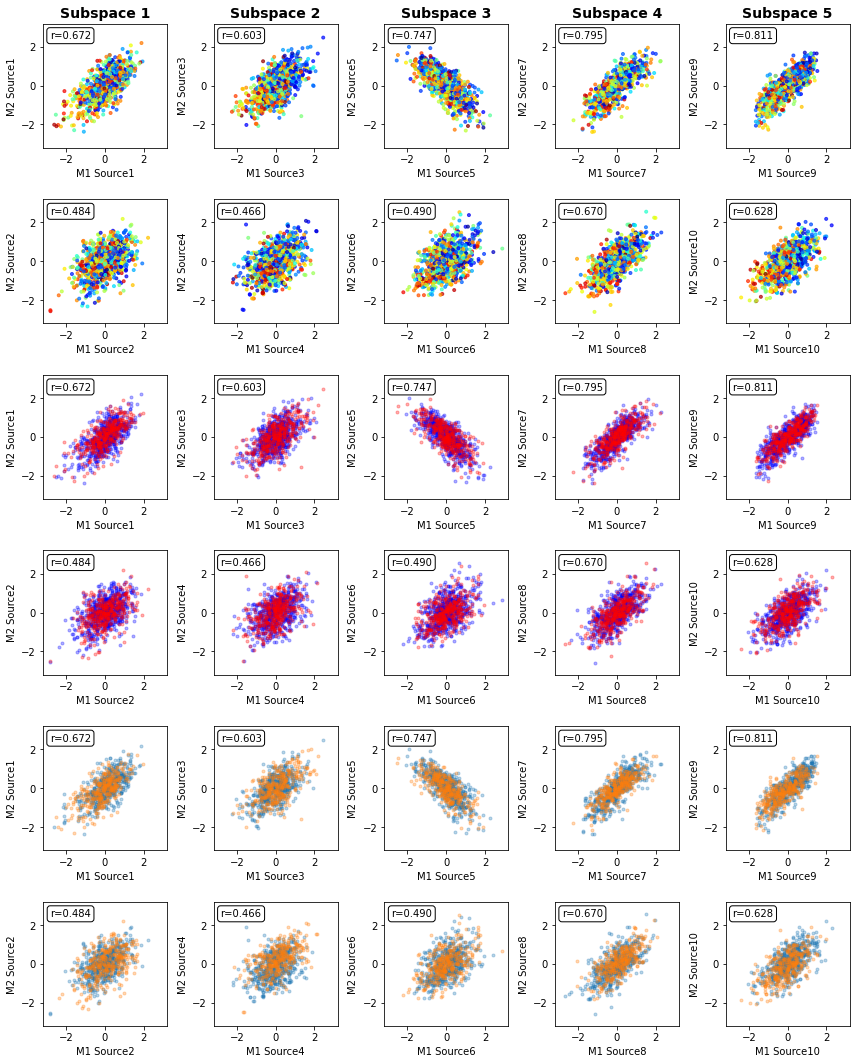

In [11]:
cols = plt.cm.jet(np.linspace(0,1,round(max(age)-min(age)+1)))

# CCA, color coded by age/sex
scv_list = []
for i in np.arange(0,10,2):
    scv_list.append([f"Source{i+1}", f"Source{i+2}"])

fig, axes = plt.subplots(6,5,figsize=(12,15))

for k in range(5):
    for i in range(2):
        WAY1 = WAY_list[k][0]#[:,id]
        WAY2 = WAY_list[k][1]#[:,id]

        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]
            # print(np.sign(correlation(WAY1[j,:],age)))
            # print(np.sign(correlation(WAY2[j,:],age)))

        axes[i+2,k].scatter(WAY1[i][sex==0], WAY2[i][sex==0],color='b',marker='.',alpha=0.3)
        axes[i+2,k].scatter(WAY1[i][sex==1], WAY2[i][sex==1],color='r',marker='.',alpha=0.3)

        axes[i+4,k].scatter(WAY1[i][diagnosis==0], WAY2[i][diagnosis==0],color=sns.color_palette("tab10")[0],marker='.',alpha=0.3)
        axes[i+4,k].scatter(WAY1[i][diagnosis==1], WAY2[i][diagnosis==1],color=sns.color_palette("tab10")[1],marker='.',alpha=0.3)
        # axes[i+4,k].scatter(WAY1[i][diagnosis==2], WAY2[i][diagnosis==2],color=sns.color_palette("tab10")[2],marker='.',alpha=0.3)
        # axes[i+4,k].scatter(WAY1[i][diagnosis==3], WAY2[i][diagnosis==3],color=sns.color_palette("tab10")[3],marker='.',alpha=0.3)
        # axes[i+4,k].scatter(WAY1[i][diagnosis==4], WAY2[i][diagnosis==4],color=sns.color_palette("tab10")[4],marker='.',alpha=0.3)
        # axes[i+4,k].scatter(WAY1[i][diagnosis==5], WAY2[i][diagnosis==5],color=sns.color_palette("tab10")[5],marker='.',alpha=0.3)

        r = format(round(cca_corr_list[k][i,i],3), '.3f')

        col = np.zeros((len(age),4))
        for n in range(len(age)):
            colorind = round(age[n]-min(age))
            col[n] = cols[colorind]
        axes[i,k].scatter(WAY1[i], WAY2[i], color=col, marker='.', alpha=0.7)

        for l in [0, 2, 4]:
            axes[i+l,k].set_aspect('equal', 'box')
            axes[i+l,k].set_xlabel(f'M1 {scv_list[k][i]}')
            axes[i+l,k].set_ylabel(f'M2 {scv_list[k][i]}')
            axes[i+l,k].set_xlim([-3.2,3.2])
            axes[i+l,k].set_ylim([-3.2,3.2])
            axes[i+l,k].annotate(f'r={r}', xy=(48, 117), xycoords='axes points',
                size=10, ha='right', va='top',
                bbox=dict(boxstyle='round', fc='w'))

        if i == 0:
            axes[i,k].set_title(f"Subspace {k+1}", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("cca_age_sex_sz_sign_adjusted.pdf")
# plt.savefig("cca_age_sex_sz_sign_adjusted.png", dpi=500)

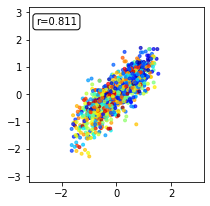

In [22]:
k=4
i=0

WAY1 = WAY_list[k][0]
WAY2 = WAY_list[k][1]

sign1 = np.sign(correlation(WAY1,age))
sign2 = np.sign(correlation(WAY2,age))
for j in range(2):
    WAY1[j,:] = -sign1[j]*WAY1[j,:]
    WAY2[j,:] = -sign2[j]*WAY2[j,:]

r = format(round(cca_corr_list[k][i,i],3), '.3f')

col = np.zeros((len(age),4))
for n in range(len(age)):
    colorind = round(age[n]-min(age))
    col[n] = cols[colorind]

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(WAY1[i], WAY2[i], color=col, marker='.', alpha=0.7)
ax.set_aspect('equal', 'box')
ax.set_xlim([-3.2,3.2])
ax.set_ylim([-3.2,3.2])
ax.annotate(f'r={r}', xy=(48, 165), xycoords='axes points',
    size=10, ha='right', va='top',
    bbox=dict(boxstyle='round', fc='w'))

plt.tight_layout()
plt.savefig("cca_age_sex_sz_sign_adjusted_age_subspace5_source9.png",dpi=500)

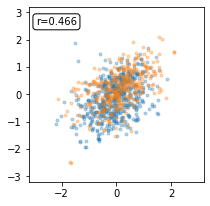

In [25]:
k=1
i=1

WAY1 = WAY_list[k][0]
WAY2 = WAY_list[k][1]

sign1 = np.sign(correlation(WAY1,age))
sign2 = np.sign(correlation(WAY2,age))
for j in range(2):
    WAY1[j,:] = -sign1[j]*WAY1[j,:]
    WAY2[j,:] = -sign2[j]*WAY2[j,:]

r = format(round(cca_corr_list[k][i,i],3), '.3f')

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(WAY1[i][diagnosis==0], WAY2[i][diagnosis==0],color=sns.color_palette("tab10")[0],marker='.',alpha=0.3)
ax.scatter(WAY1[i][diagnosis==1], WAY2[i][diagnosis==1],color=sns.color_palette("tab10")[1],marker='.',alpha=0.3)
ax.set_aspect('equal', 'box')
ax.set_xlim([-3.2,3.2])
ax.set_ylim([-3.2,3.2])
ax.annotate(f'r={r}', xy=(48, 165), xycoords='axes points',
    size=10, ha='right', va='top',
    bbox=dict(boxstyle='round', fc='w'))

plt.tight_layout()
plt.savefig("cca_age_sex_sz_sign_adjusted_sex_subspace2_source4.png",dpi=500)

In [127]:
def age_regression(X_train, X_test, y_train, y_test, a = 1):
    clf = Ridge(alpha=a) 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mae = np.mean(np.abs(y_pred-y_test))
    return mae

def sex_classification(X_train, X_test, y_train, y_test, c=1):
    # clf = SVC(kernel='linear',C=c)
    clf = LinearSVC(C=c)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(y_pred[:10])
    acc = 1 - np.mean(np.abs(y_pred-y_test))
    return acc

def sz_classification(X_train, X_test, y_train, y_test, c=1):
    clf = LinearSVC(C=c)#,multi_class='crammer_singer'
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = 1 - np.mean(np.abs(y_pred-y_test))
    return acc

In [72]:
regularizer_range = np.linspace(0.1, 1, 10)
param_grid_rr = [{'alpha': regularizer_range}]
param_grid_svm = [{'C': regularizer_range}]
param_grid_svm

[{'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

In [128]:
for i in range(5):

    X12 = (np.concatenate( (WAY_list[i][0], WAY_list[i][1]), axis=0 )).T

    X_train, X_test, y_train, y_test = train_test_split(X12, age, test_size=0.3, random_state=42)
    base_estimator = Ridge()
    rr = GridSearchCV(base_estimator, param_grid_rr, cv=10).fit(X_train, y_train)
    mae = age_regression(X_train, X_test, y_train, y_test, a=rr.best_params_['alpha'])

    X_train, X_test, y_train, y_test = train_test_split(X12, sex, test_size=0.3, random_state=42)
    # print(i, X_test[:5])
    base_estimator = SVC()
    svc = GridSearchCV(base_estimator, param_grid_svm, cv=10).fit(X_train, y_train)
    acc_sex = sex_classification(X_train, X_test, y_train, y_test, c=svc.best_params_['C'])

    # X_train, X_test, y_train, y_test = train_test_split(X12, diagnosis, test_size=0.3, random_state=42)
    X12_subset = X12[diagnosis < 2, :]
    diagnosis_subset = diagnosis[diagnosis < 2]
    X_train, X_test, y_train, y_test = train_test_split(X12_subset, diagnosis_subset, test_size=0.3, random_state=42)
    base_estimator = SVC()
    svc = GridSearchCV(base_estimator, param_grid_svm, cv=10).fit(X_train, y_train)
    acc_diagnosis = sz_classification(X_train, X_test, y_train, y_test, c=svc.best_params_['C'])

    print(f"Subspace {i+1}, Age Regression MAE {round(mae, 4)}, Sex Classification Accuracy {round(acc_sex, 4)}, Diagnosis Classification Accuracy {round(acc_diagnosis, 4)}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Subspace 1, Age Regression MAE 10.6943, Sex Classification Accuracy 0.5967, Diagnosis Classification Accuracy 0.597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Subspace 2, Age Regression MAE 9.632, Sex Classification Accuracy 0.5967, Diagnosis Classification Accuracy 0.6768
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Subspace 3, Age Regression MAE 10.6158, Sex Classification Accuracy 0.5967, Diagnosis Classification Accuracy 0.6084
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Subspace 4, Age Regression MAE 10.7383, Sex Classification Accuracy 0.5967, Diagnosis Classification Accuracy 0.597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Subspace 5, Age Regression MAE 9.4613, Sex Classification Accuracy 0.5967, Diagnosis Classification Accuracy 0.6388


In [14]:
A_ = np.zeros( (2, 10, 44318) ) #2 modalities, 10 sources, 44318 voxels

for j, i in enumerate(np.arange(0,10,2)):
# for j, i in enumerate([0]):
    # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
    A1 = A[1,1,0,:,i:i+2] # structure 2, MSIVA, M1, subspace 1
    A2 = A[1,1,1,:,i:i+2] # structure 2, MSIVA, M2, subspace 1

    Y1 = Y[1,1,0,i:i+2] 
    Y2 = Y[1,1,1,i:i+2] 

    AY1 = A1@Y1
    AY2 = A2@Y2

    WAY1 = WAY_list[j][0]
    WAY2 = WAY_list[j][1]

    sign1 = np.sign(correlation(WAY1,age))
    sign2 = np.sign(correlation(WAY2,age))
    for j in range(2):
        WAY1[j,:] = -sign1[j]*WAY1[j,:]
        WAY2[j,:] = -sign2[j]*WAY2[j,:]
    
    A1_ = (np.linalg.inv(WAY1 @ WAY1.T) @ (WAY1 @ AY1.T)).T
    A2_ = (np.linalg.inv(WAY2 @ WAY2.T) @ (WAY2 @ AY2.T)).T

    A_[0,i] = A1_[:,0]
    A_[1,i] = A2_[:,0]

    A_[0,i+1] = A1_[:,1]
    A_[1,i+1] = A2_[:,1]

sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/CCA_A_sz_10scv_correct.mat", {"A":A_})

In [26]:
maskpath="/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/gmMask_TPM_thrp2_fractc8_3mm.nii"
maskfile=nib.load(maskpath)
mask=maskfile.get_fdata()

cca_vol=sio.loadmat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/CCA_vol3d_sz_10scv_correct.mat")['vol3d']
cca_vol.shape

(2, 10, 61, 73, 61)

/Users/xli77/miniconda3/envs/nhpseg/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


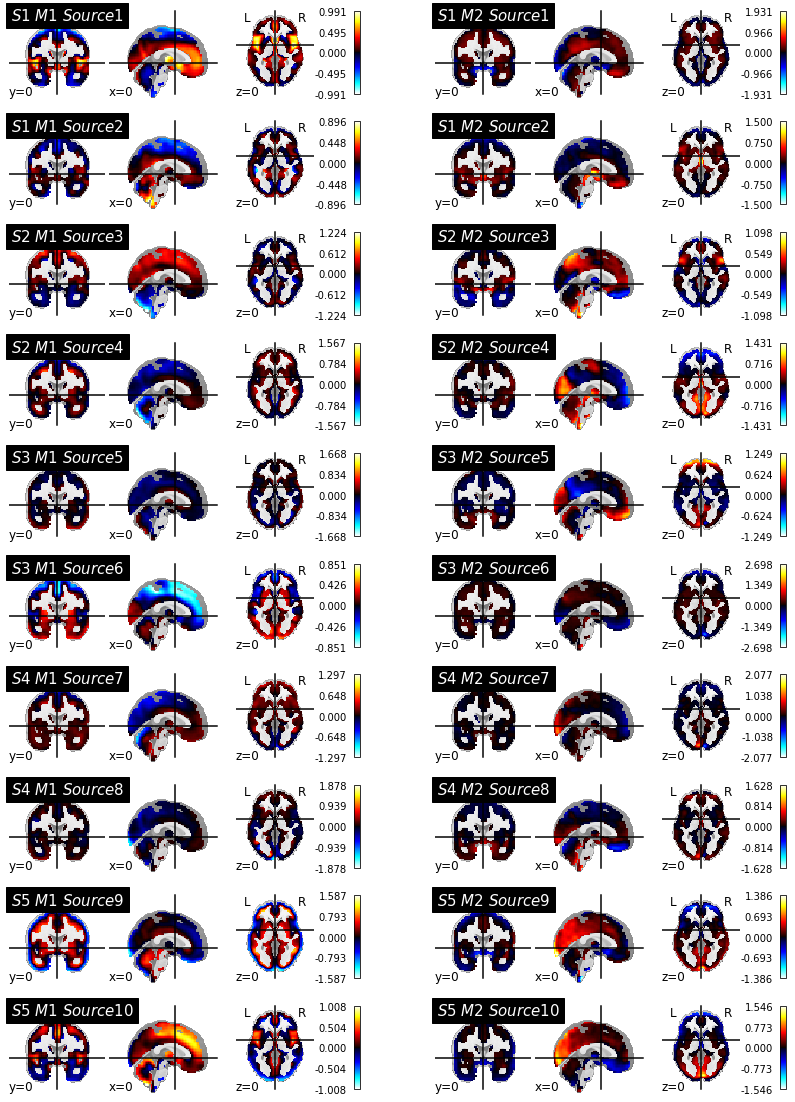

In [29]:
num_rows = 10
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(14,20))

for i in range(num_rows):
    for j in range(num_cols):
        v = cca_vol[j,i]
        img = nib.Nifti1Image(v,maskfile.affine)
        plotting.plot_stat_map(img,title=f"$S{i//2+1}$ $M{j+1}$ $Source{i+1}$",colorbar=True,cut_coords=(0,0,0),cbar_tick_format='%.3f',axes=axes[i,j])

# fig.savefig(f'cca_stat_map_xyz000_label_sz.pdf', bbox_inches = 'tight', pad_inches = 0)
fig.savefig(f'cca_stat_map_xyz000_label_sz.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)